In [1]:
import sys; sys.path.append('../../') 

from utils.data_cleaner import *
from data_collection_config import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

### Чтение и подготовка данных

In [ ]:
Goods = pd.read_csv(f'{CLEAR_DIRECTORY}{CLEAR_GOODS_FILE}')
Other_characteristicks = pd.read_csv(f'{CLEAR_DIRECTORY}{CLEAR_OTHER_CHARACTERISTICKS_FILE}')

def prepare_goods(df):
    df['brand'] = df['brand'].fillna('Unknown')
    df['description'] = df['description'].fillna('')
    df['brand'] = df['brand'].str.lower().str.strip()
    
    return df

def prepare_other_chars(df):
    df['name'] = df['name'].str.lower().str.strip()
    df['value'] = df['value'].str.lower().str.strip()
    
    df = df[df['value'].notna() & (df['value'] != '')]
    
    return df


Goods = prepare_goods(Goods)
Other_characteristicks = prepare_other_chars(Other_characteristicks)

# Goods.info()
# Other_characteristicks.info()
# Feedbacks.info()

In [5]:
Other_characteristicks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     159 non-null    object
 1   name    159 non-null    object
 2   value   159 non-null    object
dtypes: object(3)
memory usage: 3.9+ KB


## Выделение главных характеристик

In [6]:
print("Всего уникальных характеристик:", Other_characteristicks['name'].nunique())
print(Other_characteristicks['name'].value_counts().head(50))

Всего уникальных характеристик: 15
name
количество каналов                                                14
съёмные электроды                                                 14
количество программ                                               14
система учета                                                     14
страна производства                                               14
срок гарантии                                                     14
оценка качества                                                   14
стоимость костюма                                                 13
количество костюмов, необходимое для коммерческой эксплуатации    12
срок службы костюмов при большой загрузке                         12
стоимость эксплуатации в год                                      10
комплектация                                                       9
стоимость коммерческой эксплуатации в год                          3
срок службы костюма                                            

In [10]:
pivot_df = Other_characteristicks.pivot_table(
    index=['url'],
    columns='name',
    values='value',
    aggfunc='first'
).reset_index()

pivot_df.columns.name = None

main_specs = pivot_df[
    [
        'url', 'количество каналов', 
        'съёмные электроды',  'количество программ', 
        'система учета', 'страна производства',
        'срок службы костюмов при большой загрузке'
    ]
]

# main_specs['комплектация'] = main_specs['комплектация'].str.replace(r'\D', '', regex=True)

main_specs

,url,количество каналов,съёмные электроды,количество программ,система учета,страна производства,срок службы костюмов при большой загрузке
0,https://emsnoble.ru/catalog/for-home/,NaN,NaN,NaN,NaN,NaN,NaN
1,https://shopems.ru/ems-oborudovanie/amplicube,8,✔,30,✔,германия,12 месяцев
2,https://shopems.ru/ems-oborudovanie/amplitrain,6,✔,35,✔,германия,12 месяцев
3,https://shopems.ru/ems-oborudovanie/aq8,10,нет,4,нет,испания-китай,12 месяцев
4,https://shopems.ru/ems-oborudovanie/easymotion...,8,нет,4,✔,германия,6-12 месяцев
5,https://shopems.ru/ems-oborudovanie/imotion,10,✔,10,нет,испания,12 месяцев
6,https://shopems.ru/ems-oborudovanie/innline,11,✔,4,нет,польша,24 месяца
7,https://shopems.ru/ems-oborudovanie/justfit,10,✔,4,✔,венгрия,24 месяца
8,https://shopems.ru/ems-oborudovanie/justfithome,11,нет,9,✔,венгрия,NaN
9,https://shopems.ru/ems-oborudovanie/miha-bodytec,10,нет,10,✔,германия,24 месяца


# Анализ рынка EMS-костюмов

## Введение

Необходимо понять, как выглядит текущая рыночная ситуация на рынке EMS-костюмов. 

Были сформулированы 4 цели:
- Определить, в каком ценовом сегменте выгоднее всего конкурировать
- Понять, какие функции и характеристики наиболее популярны у потребителей
- Оценить уровень конкуренции
- Выявить возможные ниши

## Описание источников и подхода к сбору данных

Для достижения поставленных целей в первую очередь необходимо подготовить набор данных. Данные собраны с:
- https://shopems.ru - поставщик ems-оборудования
- https://emsnoble.ru - производитель ems-оборудования NobleRise

С обоих площадок было собрано 18 товаров.

После сбора, данные были собраны в 2 таблицы:
- Goods (основные характеристики товаров)
- Other_characteristics (доп. характеристики)

Данное оборудование имеет высокую цену и является профессиональным оборудованием, которое как правило покупают для комерческого использования, на рынке представлено ограниченное число моделей данного оборудования. Отзывы покупателей на конкретные модели оборудования не предоставлялись в источниках.

Состав таблиц:

In [11]:
Goods.info()
Other_characteristicks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   url          18 non-null     object 
 1   name         18 non-null     object 
 2   price        17 non-null     float64
 3   rating       0 non-null      float64
 4   feedbacks    0 non-null      float64
 5   brand        18 non-null     object 
 6   description  18 non-null     object 
dtypes: float64(3), object(4)
memory usage: 1.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     159 non-null    object
 1   name    159 non-null    object
 2   value   159 non-null    object
dtypes: object(3)
memory usage: 3.9+ KB


## Как выглядит рынок кабелей для электродов? (Распределение цен)

In [12]:
price_data = Goods['price'].copy()

stats = {
    'Средняя цена': f"{price_data.mean():,.0f} руб",
    'Медианная цена': f"{price_data.median():,.0f} руб",
    'Минимальная цена': f"{price_data.min():,.0f} руб",
    'Максимальная цена': f"{price_data.max():,.0f} руб",
    'Стандартное отклонение': f"{price_data.std():,.0f} руб",
    '95-й перцентиль': f"{price_data.quantile(0.95):,.0f} руб"
}

print("Ключевые метрики распределения цен:")
for k, v in stats.items():
    print(f"{k}: {v}")

Ключевые метрики распределения цен:
Средняя цена: 1,117,294 руб
Медианная цена: 1,200,000 руб
Минимальная цена: 220,000 руб
Максимальная цена: 1,650,000 руб
Стандартное отклонение: 383,699 руб
95-й перцентиль: 1,558,000 руб


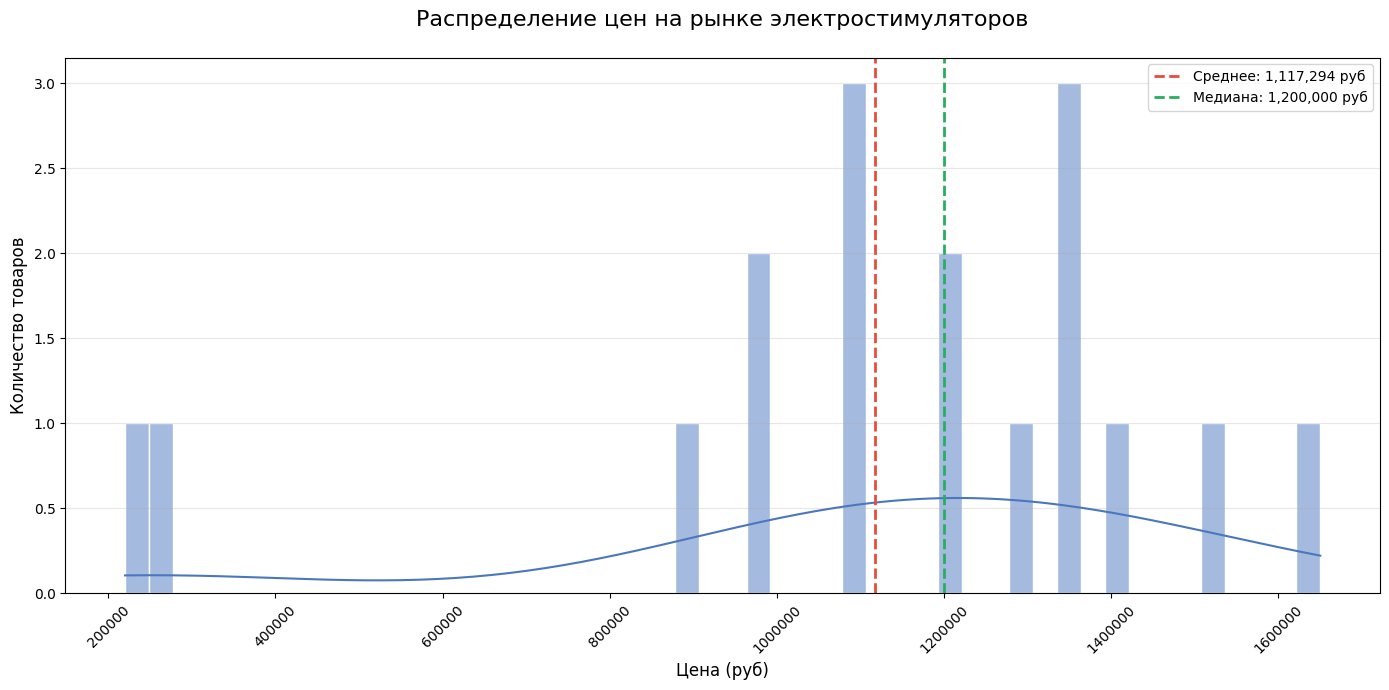

In [15]:
price_data = Goods["price"]

plt.figure(figsize=(14, 7))

ax = sns.histplot(price_data, bins=50, kde=True, 
                 color='#4B77BE', edgecolor='white')

mean_price = price_data.mean()
median_price = price_data.median()

plt.axvline(mean_price, color="#E74C3C", linestyle='--', 
           linewidth=2, label=f'Среднее: {mean_price:,.0f} руб')
plt.axvline(median_price, color='#27AE60', linestyle='--',
           linewidth=2, label=f'Медиана: {median_price:,.0f} руб')

plt.title('Распределение цен на рынке электростимуляторов\n', fontsize=16)
plt.xlabel('Цена (руб)', fontsize=12)
plt.ylabel('Количество товаров', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [24]:
price_segment_clear_df = Goods.copy()

# Создаем маску для не-NaN значений
non_na_mask = price_segment_clear_df["price"].notna()

# Кластеризуем только не-NaN значения
prices = price_segment_clear_df.loc[non_na_mask, "price"].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=4, random_state=42).fit(prices)

# Создаем колонку и заполняем только для не-NaN
price_segment_clear_df['price_segment'] = np.nan
price_segment_clear_df.loc[non_na_mask, 'price_segment'] = kmeans.labels_

def min_max(price_segment, df):
    return int(df[df["price_segment"] == price_segment]["price"].min()), int(df[df["price_segment"] == price_segment]["price"].max())

min_max_segments = {}
for i in range(4):
    min_max_segments[i] = min_max(i, price_segment_clear_df)

min_max_segments = sorted(min_max_segments.items(), key=lambda item: item[1] )

print(f"Низкий ценовой сегмент: {min_max_segments[0][1]}")
print(f"Средний ценовой сегмент: {min_max_segments[1][1]}")
print(f"Средне-высокий ценовой сегмент:{min_max_segments[2][1]}")
print(f"Высокий ценовой сегмент:  {min_max_segments[3][1]}")

Низкий ценовой сегмент: (220000, 269000)
Средний ценовой сегмент: (900000, 990000)
Средне-высокий ценовой сегмент:(1100000, 1200000)
Высокий ценовой сегмент:  (1300000, 1650000)


In [27]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

def top_specs(df, column, top_n, stats):
    zones = df[column].str.split('[;,/]', expand=True).stack().str.strip()
    top_zones = zones.value_counts().head(top_n)
    stats.update({
        f'топ {top_n} {column}': '; '.join([f"{zone} ({count})" for (zone, count) in top_zones.items()])
    })

def get_segment_stats(segment_df, segment_name, top_n):
    stats = {
        'Сегмент': segment_name,
        'Кол-во товаров': len(segment_df),
        'Доля товаров без бренда': len(segment_df[segment_df['brand'] == 'unknown']) / len(segment_df),
    }
    
    # Топ брендов
    top_brands = segment_df['brand'].value_counts().head(top_n)
    stats.update({
        f'топ {top_n} брендов': '; '.join([f"{brand} ({count})" for (brand, count) in top_brands.items()])
    })
    
    return stats

low_price_df = price_segment_clear_df[price_segment_clear_df["price_segment"] == min_max_segments[0][0]]
mid_price_df = price_segment_clear_df[price_segment_clear_df["price_segment"] == min_max_segments[1][0]]
mid_high_price_df = price_segment_clear_df[price_segment_clear_df["price_segment"] == min_max_segments[2][0]]
high_price_df = price_segment_clear_df[price_segment_clear_df["price_segment"] == min_max_segments[3][0]]

segments = {
    'Низкий': low_price_df,
    'Средний': mid_price_df,
    'Средне-высокий': mid_high_price_df,
    'Высокий': high_price_df
}

top_n = 5
all_stats = [get_segment_stats(df, name, top_n) for name, df in segments.items()]
result_df = pd.DataFrame(all_stats)

display(result_df)
pd.reset_option('display.max_colwidth')

,Сегмент,Кол-во товаров,Доля товаров без бренда,топ 5 брендов
0,Низкий,2,0.0,justfit (1); noblerise (1)
1,Средний,3,0.0,xbody (1); amplitrain (1); aq8 (1)
2,Средне-высокий,5,0.0,justfit (1); innline (1); imotion (1); visionbody (1); wiemspro (1)
3,Высокий,7,0.0,xbody (2); stimawell (2); miha (1); loncego (1); amplicube (1)


## 1. О рынке

**Рынок компактный:**
- Всего 18 товаров в анализе
- Цены колеблются от 220к до 1 650k руб

Моделей ems-костюмов на рынке не много, данный вид товаров можно отнести в специализированному медицинскому оборудованию, соотвественно оно довольно узко представлено на рынке и стоит дорого. 

Минимальная цена за ems-костюм составляет 220к руб., максимальная 1 650к руб., средняя цена 1 117 294 руб.

В основном производители иностранные, однако можно выделить Российскую компанию NobleRise, которая производит и продает данное оборудование по относительно доступной цене 269 000 руб.

/var/folders/x5/m9f65fq57_1642g0ls7c0zxw0000gn/T/ipykernel_40318/1095736399.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


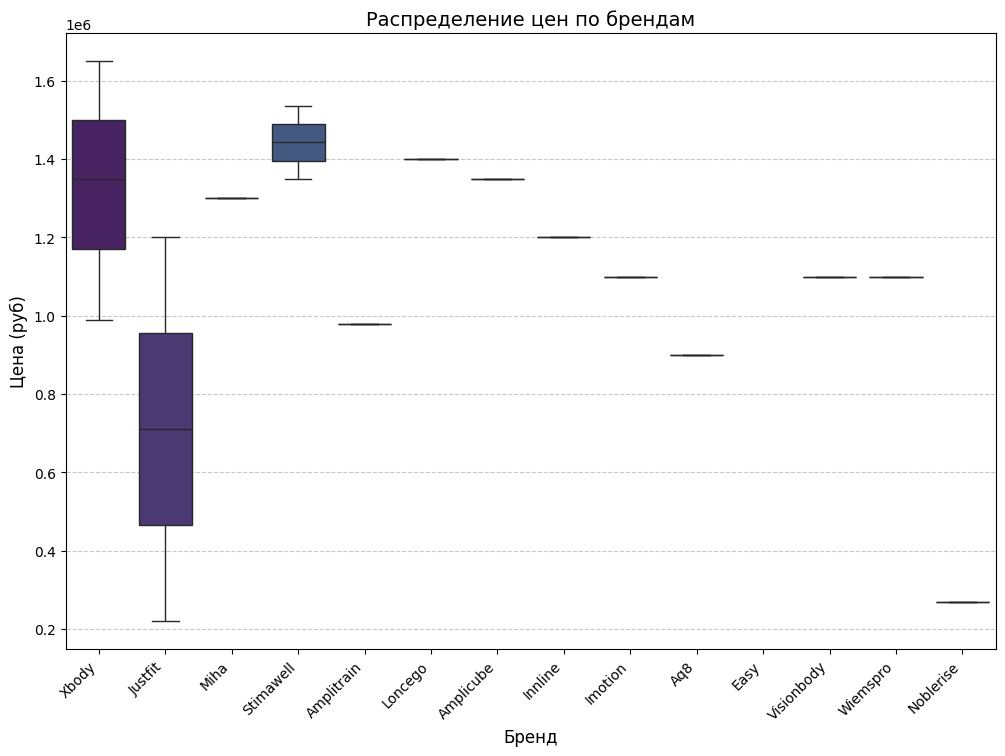

In [29]:
clear_df = Goods.copy()

boxplot_df = clear_df.dropna(subset=["brand"])
boxplot_df['brand'] = boxplot_df['brand'].str.strip().str.title()

top_brands = boxplot_df['brand'].value_counts().head(20).index  # Топ-20 брендов
df_filtered = boxplot_df[boxplot_df['brand'].isin(top_brands)]

plt.figure(figsize=(12, 8))
sns.boxplot(
    data=df_filtered,
    x='brand',
    y='price',
    palette='viridis'
)
plt.title('Распределение цен по брендам', fontsize=14)
plt.xlabel('Бренд', fontsize=12)
plt.ylabel('Цена (руб)', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Поворот подписей
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [30]:
Goods['brand'].value_counts().head(20)

brand
xbody         3
justfit       2
stimawell     2
miha          1
amplitrain    1
loncego       1
amplicube     1
innline       1
imotion       1
aq8           1
easy          1
visionbody    1
wiemspro      1
noblerise     1
Name: count, dtype: int64

Все товары данной категории брендированы производителем.

## Реакция потребителей (Анализ отзывов и рейтингов)

Что касается самых популярных характерстик:

In [31]:
def plot_top_main_specs(df, column, top_n, color):
    spec_df = df[column].str.split('[;,/]', expand=True).stack().str.strip()

    figsize = (15, 3)

    plt.figure(figsize=figsize)
    spec_df.value_counts().head(top_n).plot(kind='bar', color=color)
    plt.title(f'Топ-{top_n} {column}')
    plt.ylabel('Количество товаров')
    plt.xticks(rotation=30)
    plt.grid(axis='y', alpha=0.3)
    plt.show()

In [32]:
main_specs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 7 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   url                                        15 non-null     object
 1   количество каналов                         14 non-null     object
 2   съёмные электроды                          14 non-null     object
 3   количество программ                        14 non-null     object
 4   система учета                              14 non-null     object
 5   страна производства                        14 non-null     object
 6   срок службы костюмов при большой загрузке  12 non-null     object
dtypes: object(7)
memory usage: 972.0+ bytes


In [43]:
percent_removable_electrodes = (len(main_specs[main_specs['съёмные электроды'] == '✔']) / (len(main_specs) - 1)) * 100 
percent_control_system = (len(main_specs[main_specs['система учета'] == '✔']) / (len(main_specs) - 1)) * 100

print(f'Процент костюмов со съемными электродами: {percent_removable_electrodes}')
print(f'Процент костюмов с стистемой контроля: {percent_control_system}')

Процент костюмов со съемными электродами: 64.28571428571429
Процент костюмов с стистемой контроля: 78.57142857142857


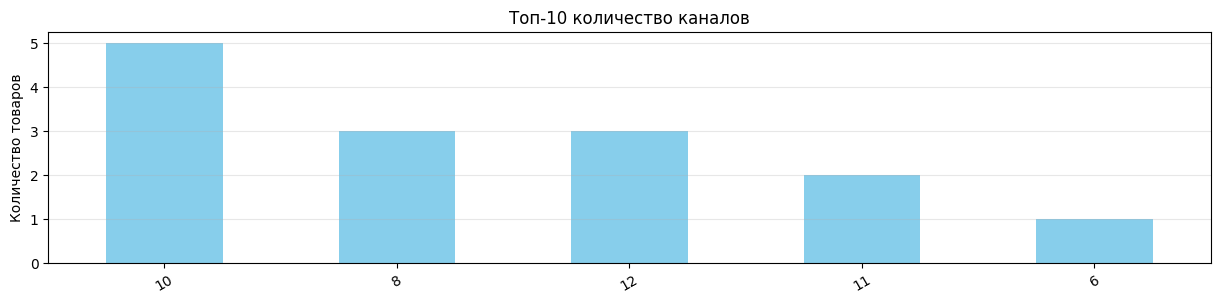

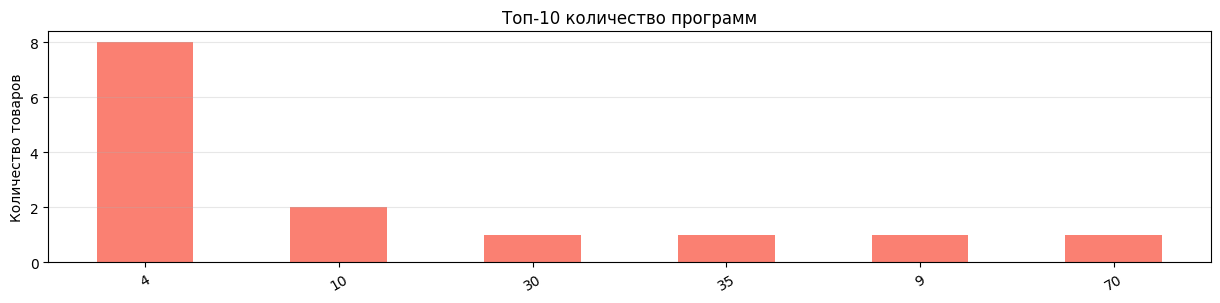

In [35]:
plot_top_main_specs(main_specs, 'количество каналов', 10, 'skyblue')
plot_top_main_specs(main_specs, 'количество программ', 10, 'salmon')

Основную часть рынка составляют костюмы с 10 каналами, 4 программами, имеющие съемные электроды и систему контроля.

Высоким рейтингом обладают товары среднего ценового сегмента.

## Выводы:

Идеальный продукт выглядит так: костюм с 10 каналами, 4 программами, имеющий съемные электроды и систему контроля.

Конкуренция на рынке низкая, поскольку продажами товаров данной категории занимаются немногочисленные специализрованные магазины и проихводители.